## 1. Replicate the baseline AI methodology using the open dataset 
### a. Clone original repository successfully 
### b. Document all dependencies and environment setup 
### c. Reproduce baseline results within ±5% of original paper metrics 
### d. Provide reproducible notebook or Python scripts 

In [1]:
#!git clone https://github.com/jrterven/eurosat_classification.git
#!pip install scikit-learn
#!pip install seaborn
#!pip install wandb
#!pip install --upgrade typing_extensions
#!pip install pickleshare

In [2]:
import os
project_path = '/root/eurosat_classification'
%cd "{project_path}"

/root/eurosat_classification


In [3]:
# import zipfile
# import urllib.request
# import os

# # 1. Create the "data" folder
# data_dir = 'data'
# if not os.path.exists(data_dir):
#     os.makedirs(data_dir)

# # 2. Download EuroSAT (RGB version)
# url = 'http://madm.dfki.de/files/sentinel/EuroSAT.zip'
# zip_path = os.path.join(data_dir, 'EuroSAT.zip')

# if not os.path.exists(zip_path):
#     print("Downloading EuroSAT dataset (around 90MB)...")
#     urllib.request.urlretrieve(url, zip_path)
#     print("Download Complete !")
# else:
#     print("The compressed package already exists.")

# # 3. Unzip
# extract_path = os.path.join(data_dir, 'EuroSAT')
# if not os.path.exists(extract_path):
#     print("Decompressing...")
#     with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#         zip_ref.extractall(data_dir)
#     print("Unzip completed")
# else:
#     print("The data has been unziped.")

In [4]:
# Verify the file structure
# should be able to see AnnualCrop, Forest and other folders
!ls data/2750/

AnnualCrop	      Highway	  PermanentCrop  SeaLake	 train.csv
Forest		      Industrial  Residential	 label_map.json  validation.csv
HerbaceousVegetation  Pasture	  River		 test.csv


# EuroSat Image Classification using ResNet

Hector Becerra  
Juan Terven  
2023

**ResNet**, short for Residual Network, is a groundbreaking convolutional neural network (CNN) architecture that revolutionized deep learning in computer vision. Introduced by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun in 2015, it won the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) that year. ResNet's defining feature is its use of *residual blocks*, which incorporate shortcut connections (or "skip connections") that allow the input of a layer to be added to its output, thereby addressing the vanishing gradient problem and enabling the training of networks with unprecedented depths, up to hundreds or even thousands of layers. This design significantly improved the accuracy of image recognition tasks and has influenced a wide range of subsequent neural network architectures, solidifying ResNet as a foundational model in deep learning.

In [5]:
%cd "{project_path}/train_eval_code"

/root/eurosat_classification/train_eval_code


In [6]:
import os
import numpy as np
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import wandb
from torch.utils.data import DataLoader
import json
from torchvision.models import resnet50,ResNet50_Weights

from train_utils import get_predictions,compute_val_loss,EarlyStopping,train_model
from eval_utils import remove_wandb_hooks,evaluate_test_set,precision_recall_analysis
from EuroSAT import EurosatDataset,visualize_classes


In [7]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
    print("Found GPU")
else:
    torch.device("cpu")

print("Pytorch version:", torch.__version__)

Found GPU
Pytorch version: 2.5.1+cu124


## Login to Wandb to log experiment

In [8]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'EuroSat_ResNet_Classifier.ipynb'

wandb.login()

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find EuroSat_ResNet_Classifier.ipynb.
wandb: Currently logged in as: xuxinmu24 (xuxinmu24-university-college-london-ucl-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# Data
The [EuroSat Dataset](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8736785) consists of 27,000 labeled images with ten different land use and land cover classes. It is multi-spectral, covering 13 spectral bands in the visible, near infrared, and short wave infrared parts of the spectrum. The dataset is geo-referenced and based on openly and freely accessible earth observation data. The classes are the following.

| No. | Land Use Type           |
|-----|-------------------------|
| 1   | AnnualCrop              |
| 2   | Forest                  |
| 3   | HerbaceousVegatation    |
| 4   | Highway                 |
| 5   | Industrial              |
| 6   | Pasture                 |
| 7   | PermanentCrop           |
| 8   | Residential             |
| 9   | River                   |
| 10  | SeaLake                 |

In [9]:
#data_path = "/datasets/eurosat/EuroSAT/"

In [10]:
%cd "{project_path}"

/root/eurosat_classification


In [11]:
import json
import os

# 1. Modify the data path
# unzipped pictures are actually in the 'data/2750/' folder
data_path = "data/2750/" # This line is , as data_path is now set by the previous cell

if not os.path.exists(data_path):
    if os.path.exists("data/AnnualCrop"):
        data_path = "data/"
    else:
        print(f"Warning: Path not found. {data_path}")

print(f"The current data path has been set to: {data_path}")

# 2. The code of the original project depends on the file: label_map.json,
# manually create a label_map.json here and write it to our data folder.
label_map = {
    "AnnualCrop": 0,
    "Forest": 1,
    "HerbaceousVegetation": 2,
    "Highway": 3,
    "Industrial": 4,
    "Pasture": 5,
    "PermanentCrop": 6,
    "Residential": 7,
    "River": 8,
    "SeaLake": 9
}

json_file_path = os.path.join(data_path, "label_map.json")

with open(json_file_path, "w") as f:
    json.dump(label_map, f)

print(f"File successfully generated: {json_file_path}")

The current data path has been set to: data/2750/
File successfully generated: data/2750/label_map.json


In [12]:
# Load the labels
f = open(f"{data_path}label_map.json", "r")
label_to_index = json.load(f)

In [13]:
index_to_label = {label_to_index[k]:k for k in label_to_index}
print(index_to_label)

{0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}


## Data Transformations

In [14]:
# Define a sequence of transformations to be applied to images
transformToTensor = transforms.Compose([
    # Resize the image to have a minimum size of 64 pixels along the shortest dimension,
    # preserving the aspect ratio of the original image.
    transforms.Resize((64,)),

    # Crop the image at the center to get a 64x64 square.
    transforms.CenterCrop((64, 64)),

    # Convert the image to a PyTorch tensor.
    transforms.ToTensor(),

    # Normalize the tensor image with mean and standard deviation for each color channel.
    # These specific values are generally used for pre-trained models.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [15]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Re-scan data (to ensure data sources are correct)
all_data = []
label_map = {
    "AnnualCrop": 0, "Forest": 1, "HerbaceousVegetation": 2,
    "Highway": 3, "Industrial": 4, "Pasture": 5,
    "PermanentCrop": 6, "Residential": 7, "River": 8, "SeaLake": 9
}

if os.path.exists(data_path):
    for category in os.listdir(data_path):
        if category in label_map:
            cat_dir = os.path.join(data_path, category)
            # Make sure it's a folder.
            if os.path.isdir(cat_dir):
                for img in os.listdir(cat_dir):
                    if img.endswith(('.jpg', '.jpeg', '.png')):
                        all_data.append({
                            'Filename': os.path.join(category, img),
                            'Label': label_map[category]
                        })

df = pd.DataFrame(all_data)

# Key Correction: Use 70% Training Set
# Original project logic :70% training,15% validation,15% testing
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['Label'], random_state=42)

val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Label'], random_state=42)

print(f"Final division details:")
print(f"Training Set: {len(train_df)}")
print(f"Validate Set: {len(val_df)} ")
print(f"Test Set: {len(test_df)} ")

# 3. Save the overwrite CSV
train_df.to_csv(os.path.join(data_path, 'train.csv'), index=False)
val_df.to_csv(os.path.join(data_path, 'validation.csv'), index=False)
test_df.to_csv(os.path.join(data_path, 'test.csv'), index=False)

Final division details:
Training Set: 18900
Validate Set: 4050 
Test Set: 4050 


In [16]:
# Create dataset instances
# Instantiate the EurosatDataset class for training data.
train_dataset = EurosatDataset(_type='train', transform=transformToTensor,
                               data_path=data_path)

# Instantiate the EurosatDataset class for validation data.
valid_dataset = EurosatDataset(_type="valid", transform=transformToTensor,
                               data_path=data_path)

# Instantiate the EurosatDataset class for testing data.
test_dataset = EurosatDataset(_type="test", transform=transformToTensor,
                              data_path=data_path)

# Define batch sizes for training and validation data.
train_batch = 64  # The batch size for training data.
val_batch = 16     # The batch size for validation data.

# Create DataLoaders
# Create a DataLoader for the training dataset. This DataLoader will automatically
# group the training data into batches of size 128 and shuffle them in each epoch.
train_loader = DataLoader(train_dataset, batch_size=train_batch, shuffle=True)

# Create a DataLoader for the validation dataset. This DataLoader groups the validation
# data into batches of size 32. The data is not shuffled, which is typical for validation data.
valid_loader = DataLoader(valid_dataset, batch_size=val_batch, shuffle=False)

# Create a DataLoader for the testing dataset. This DataLoader processes the test data
# one sample at a time (batch size of 1) and does not shuffle the data. This is typical
# for test data since we often want to evaluate the model on test data in a specific order.
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4500387..1.2042983].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5699118..0.07790857].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6726604..1.0673003].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2959158..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0561693..1.8721637].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6041614..0.008191798].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6897851.

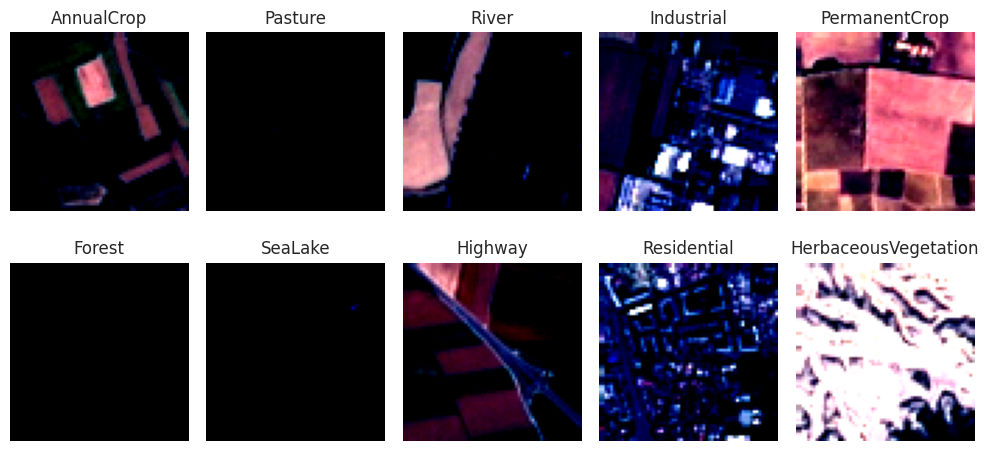

In [17]:
visualize_classes(train_loader, index_to_label)

In [18]:
dataset_managers = {
    'valid': valid_loader,
    'train': train_loader,
    'test': test_loader
}

print(f"Train set batches: {len(train_loader)}")
print(f"Validation set batches: {len(valid_loader)}")
print(f"Test set examples: {len(test_loader)}")

Train set batches: 296
Validation set batches: 254
Test set examples: 4050


## Labels distribution

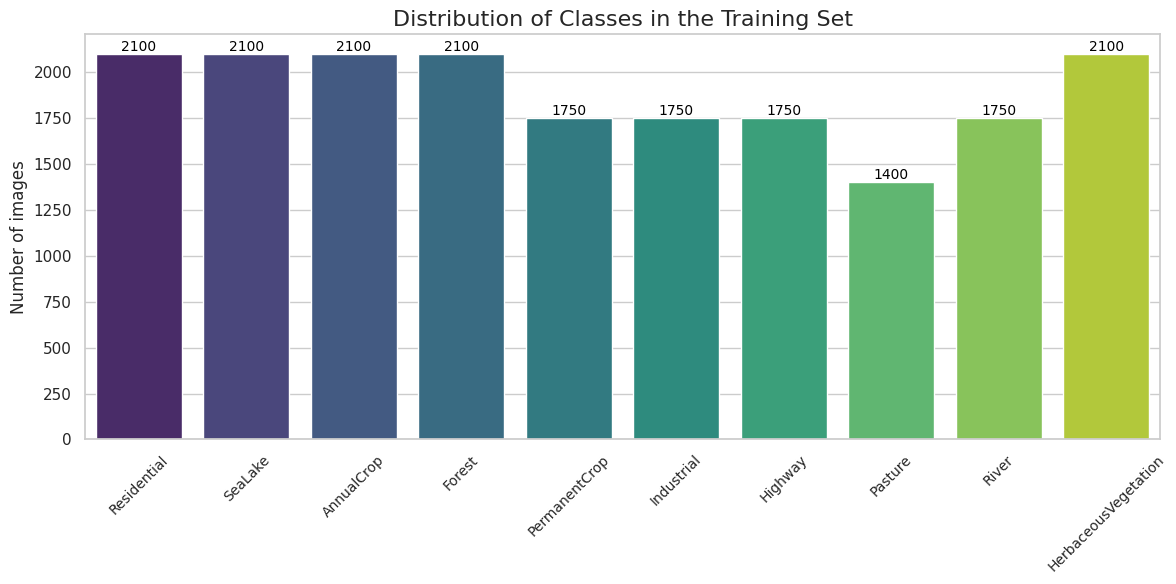

In [19]:
labels = train_dataset.data['Label'].values  # Assuming 'Label' is the column with labels

# Convert numerical labels to string names if necessary
label_names = [index_to_label[label] for label in labels]

sns.set(style="whitegrid")  # Set style
plt.figure(figsize=(12, 6))

# Adjusted according to the new API
ax = sns.countplot(x=label_names, hue=label_names, palette="viridis", legend=False)

#plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of images', fontsize=12)
plt.title('Distribution of Classes in the Training Set', fontsize=16)
plt.xticks(rotation=45, fontsize=10)

# Add the count above the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()



# Model

In [20]:
# Use un-pretrained model
model = resnet50()

# Replace the model head with the number of classes
num_classes = 10
model.fc = nn.Linear(2048, num_classes)
model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Training model from Scratch

In [21]:
project_name = "EuroSAT"
model_name = "ResNet50"
models_path = "models"
if not os.path.exists(models_path):
    os.makedirs(models_path)

In [22]:
epochs = 200
lr = 0.0001
patience = 10

run = wandb.init(
    # Set the project where this run will be logged
    project=project_name,
    name=model_name,
    notes="ResNet from scratch",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": train_batch,
        "patience": patience
    })

# loss_i, loss_val_i = train_model(model=model, epochs=epochs,
#                                  train_loader=train_loader,
#                                  valid_loader=valid_loader,
#                                  lr=lr, patience=patience, device=DEVICE)

loss_i, loss_val_i = train_model(
    model=model,
    epochs=epochs,
    train_loader=train_loader,
    valid_loader=valid_loader,
    lr=lr,
    patience=patience,
    device=DEVICE,
    model_name=model_name,   # Fix TypeError
    # models_path=models_path #
)

Starting training with early stopping patience of 10
Each epoch has 296 steps.

Epoch: 1...
Step: 21/296 Loss: 2.072326511144638
Step: 41/296 Loss: 1.7073715031147003
Step: 61/296 Loss: 1.5303600788116456
Step: 81/296 Loss: 1.4063078880310058
Step: 101/296 Loss: 1.3710413813591003
Step: 121/296 Loss: 1.2401195645332337
Step: 141/296 Loss: 1.2744067072868348
Step: 161/296 Loss: 1.237582755088806
Step: 181/296 Loss: 1.2033101350069046
Step: 201/296 Loss: 1.0843405723571777
Step: 221/296 Loss: 1.0990688413381577
Step: 241/296 Loss: 1.0752498865127564
Step: 261/296 Loss: 1.0295726865530015
Step: 281/296 Loss: 1.028572252392769
Validation Loss: 1.1098 Accuracy: 0.6109
Best model saved.
Epoch duration: 28.66s

Epoch: 2...
Step: 21/296 Loss: 1.0644254952669143
Step: 41/296 Loss: 1.1149594128131866
Step: 61/296 Loss: 1.177371534705162
Step: 81/296 Loss: 1.0767208635807037
Step: 101/296 Loss: 0.9687125742435455
Step: 121/296 Loss: 0.9908584475517273
Step: 141/296 Loss: 0.7934537142515182
Step: 

## Save model

In [23]:
import os
import torch

project_path = '/root/eurosat_classification'

models_path = os.path.join(project_path, 'models')

# Make sure the model name has been defined
if 'model_name' not in locals():
    model_name = "ResNet50_EuroSAT"

# Create folder
os.makedirs(models_path, exist_ok=True)

# Set the full path to save the file
save_file_path = os.path.join(models_path, f"{model_name}.pth")

# Save the model
print(f"Saving model to: {save_file_path}")
try:
    torch.save(model.state_dict(), save_file_path)
    print(f" Model saved successfully in: {save_file_path}")
except Exception as e:
    print(f"❌ Save failed: {e}")

Saving model to: /root/eurosat_classification/models/ResNet50.pth
 Model saved successfully in: /root/eurosat_classification/models/ResNet50.pth


In [24]:
# Save the loss data in a file
with open(f"{models_path}/loss_{model_name}.txt", "w") as file:
    file.write(f"loss_i: {loss_i}\n")
    file.write(f"loss_val_i: {loss_val_i}\n")

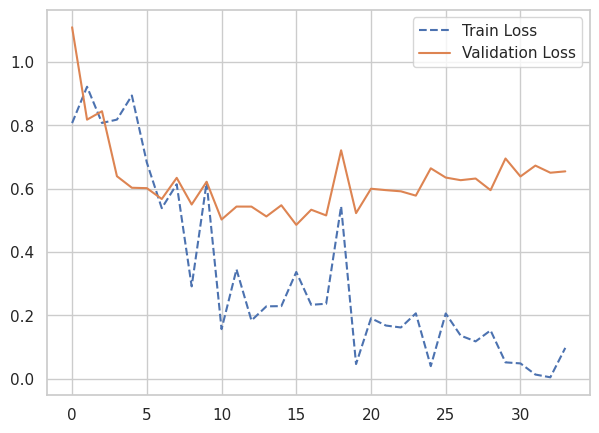

In [25]:
plt.figure(figsize=(7,5))
# Use a dashed line for the training loss, and add markers
plt.plot(loss_i, label="Train Loss", linestyle='--', alpha=1.0)

# Use a solid line for the validation loss
plt.plot(loss_val_i, label="Validation Loss", linestyle='-', alpha=1.0)
plt.legend()
plt.show()

# Evaluate model

In [26]:
# Call this function before evaluating your model to remove any wandb hook
#remove_wandb_hooks(model)

## Load trained model

In [27]:
# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
model_save_path = models_path + "/" + model_name + ".pth"
print(f"Loading {model_save_path}")
model.load_state_dict(torch.load(f = model_save_path))

Loading /root/eurosat_classification/models/ResNet50.pth


/tmp/ipykernel_1501/397842506.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f = model_save_path))


<All keys matched successfully>

In [28]:
evaluate_test_set(model, test_loader, DEVICE, index_to_label=index_to_label)

                      precision    recall  f1-score   support

          AnnualCrop      0.881     0.842     0.861       450
              Forest      0.955     0.798     0.869       450
HerbaceousVegetation      0.787     0.731     0.758       450
             Highway      0.697     0.693     0.695       375
          Industrial      0.908     0.944     0.925       375
             Pasture      0.801     0.750     0.775       300
       PermanentCrop      0.677     0.749     0.711       375
         Residential      0.970     0.940     0.955       450
               River      0.781     0.800     0.791       375
             SeaLake      0.814     0.989     0.893       450

            accuracy                          0.828      4050
           macro avg      0.827     0.824     0.823      4050
        weighted avg      0.833     0.828     0.828      4050



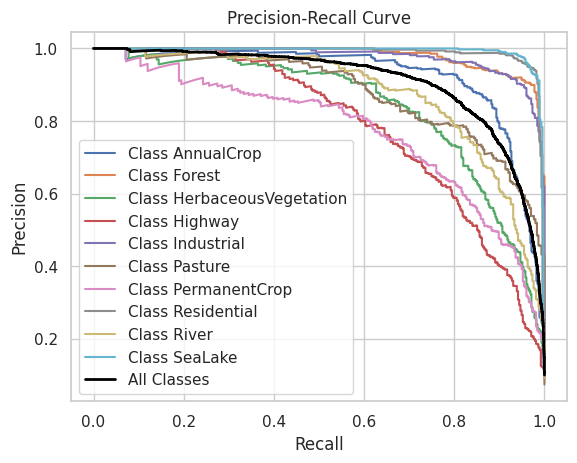

In [29]:
precision_recall_analysis(model, test_loader, DEVICE,
                          output_path=models_path,
                          model_name=model_name,
                          index_to_label=index_to_label)

In [30]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
step,▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇███
train_loss,█▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_accuracy,▁▄▄▆▆▆▆▆▇▆▇▇▇▇▇███▆█▇▇██▇████▇▇██▇
val_loss,█▅▅▃▂▂▂▃▂▃▁▂▂▁▂▁▂▁▄▁▂▂▂▂▃▃▃▃▂▃▃▃▃▃
epoch,33
step,10048
train_loss,0.06764
val_accuracy,0.82938
val_loss,0.65497


## Load the precision/recall curve and plot it

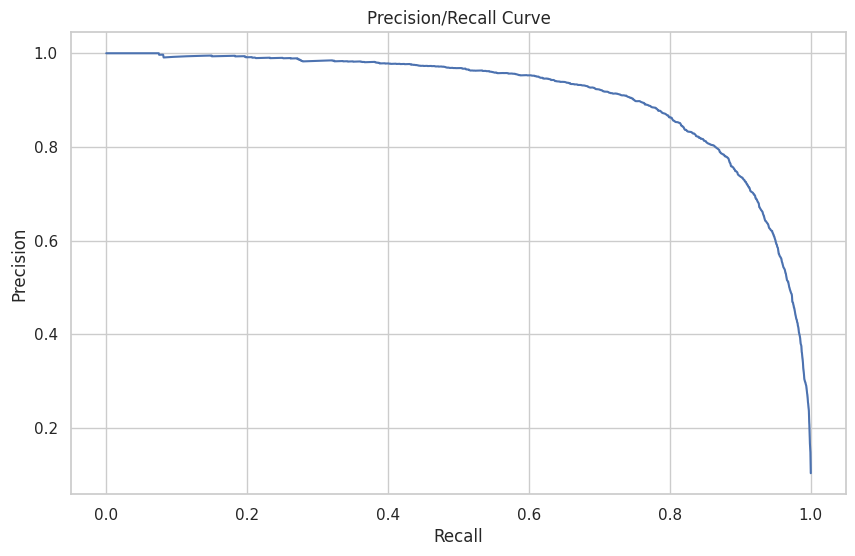

In [31]:
filename = f"{model_name}_precision_recall_values.json"
file_path = os.path.join(models_path, filename)

with open(file_path, 'r') as file:
    precision_recall_data = json.load(file)

all_classes_data = precision_recall_data['All Classes']

# Extract precision and recall values
precisions = all_classes_data.get('precision', [])
recalls = all_classes_data.get('recall', [])

# Create a DataFrame for plotting
df = pd.DataFrame({
    'Precision': precisions,
    'Recall': recalls
})

# Plotting the precision/recall curve
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Recall', y='Precision')
plt.title('Precision/Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

## Clean-up

In [32]:
import gc

del model
torch.cuda.empty_cache()
gc.collect()


28291

# Now train the model with pre-trained weights

In [33]:
# Use pretrained model
model2=resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# Replace the model head with the number of classes
num_classes = 10
model2.fc = nn.Linear(2048, num_classes)
model2.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Train

In [34]:
model_name = "ResNet50-Pretrained"

In [35]:
epochs = 200
lr = 0.0001
patience = 10

run = wandb.init(
    # Set the project where this run will be logged
    project=project_name,
    name=model_name,
    notes="ResNet pre-trained on ImageNet",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": train_batch,
        "patience": patience
    })

# loss_i, loss_val_i = train_model(model=model2, epochs=epochs,
#                                  train_loader=train_loader,
#                                  valid_loader=valid_loader,
#                                  lr=lr, patience=patience, device=DEVICE)


loss_i, loss_val_i = train_model(
    model=model2,  
    epochs=epochs,
    train_loader=train_loader,
    valid_loader=valid_loader,
    lr=lr,
    patience=patience,
    device=DEVICE,
    model_name=model_name,     
    # model_save_path=models_path  
)

Starting training with early stopping patience of 10
Each epoch has 296 steps.

Epoch: 1...
Step: 21/296 Loss: 1.3874415695667266
Step: 41/296 Loss: 0.37421800196170807
Step: 61/296 Loss: 0.294066908955574
Step: 81/296 Loss: 0.2074899457395077
Step: 101/296 Loss: 0.20396787859499454
Step: 121/296 Loss: 0.21143368631601334
Step: 141/296 Loss: 0.19539657197892665
Step: 161/296 Loss: 0.18294129595160485
Step: 181/296 Loss: 0.13838364873081446
Step: 201/296 Loss: 0.19227610006928444
Step: 221/296 Loss: 0.1749686161056161
Step: 241/296 Loss: 0.16153985895216466
Step: 261/296 Loss: 0.15136348977684974
Step: 281/296 Loss: 0.12314234785735607
Validation Loss: 0.1036 Accuracy: 0.9701
Best model saved.
Epoch duration: 32.14s

Epoch: 2...
Step: 21/296 Loss: 0.15340714789927007
Step: 41/296 Loss: 0.20508742667734622
Step: 61/296 Loss: 0.15350125767290593
Step: 81/296 Loss: 0.16485393922775984
Step: 101/296 Loss: 0.14086671844124793
Step: 121/296 Loss: 0.1747342102229595
Step: 141/296 Loss: 0.14573

## Save model

In [36]:
# Create models directory
os.makedirs(models_path, exist_ok=True)

# 2. Create model save path
model_save_path = os.path.join(models_path, model_name + ".pth")

# 3. Save the model state dict
print(f"Saving model to: {model_save_path}")
torch.save(obj=model2.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=model_save_path)

Saving model to: /root/eurosat_classification/models/ResNet50-Pretrained.pth


In [37]:
# Save the loss data in a file
with open(f"{models_path}/loss_{model_name}.txt", "w") as archivo:
    archivo.write(f"loss_i: {loss_i}\n")
    archivo.write(f"loss_val_i: {loss_val_i}\n")

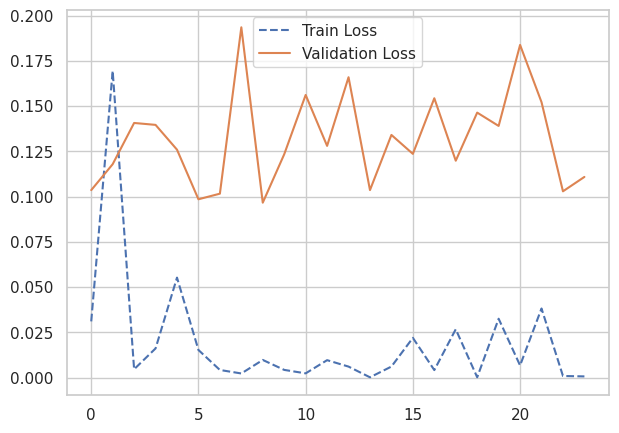

In [38]:
plt.figure(figsize=(7,5))
# Use a dashed line for the training loss, and add markers
plt.plot(loss_i, label="Train Loss", linestyle='--', alpha=1.0)

# Use a solid line for the validation loss
plt.plot(loss_val_i, label="Validation Loss", linestyle='-', alpha=1.0)
plt.legend()
plt.show()

# Evaluate model

In [39]:
# Call this function before evaluating your model to remove any wandb hook
#remove_wandb_hooks(model)

## Load trained model

In [40]:
# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
model_save_path = models_path + "/" + model_name + ".pth"
print(f"Loading {model_save_path}")
model2.load_state_dict(torch.load(f = model_save_path))

Loading /root/eurosat_classification/models/ResNet50-Pretrained.pth


/tmp/ipykernel_1501/3005568182.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load(f = model_save_path))


<All keys matched successfully>

In [41]:
evaluate_test_set(model2, test_loader, DEVICE, index_to_label=index_to_label)

                      precision    recall  f1-score   support

          AnnualCrop      0.963     0.971     0.967       450
              Forest      0.987     0.991     0.989       450
HerbaceousVegetation      0.964     0.964     0.964       450
             Highway      0.981     0.979     0.980       375
          Industrial      0.987     1.000     0.993       375
             Pasture      0.983     0.940     0.961       300
       PermanentCrop      0.952     0.957     0.955       375
         Residential      1.000     0.993     0.997       450
               River      0.973     0.973     0.973       375
             SeaLake      0.980     0.989     0.985       450

            accuracy                          0.977      4050
           macro avg      0.977     0.976     0.976      4050
        weighted avg      0.977     0.977     0.977      4050



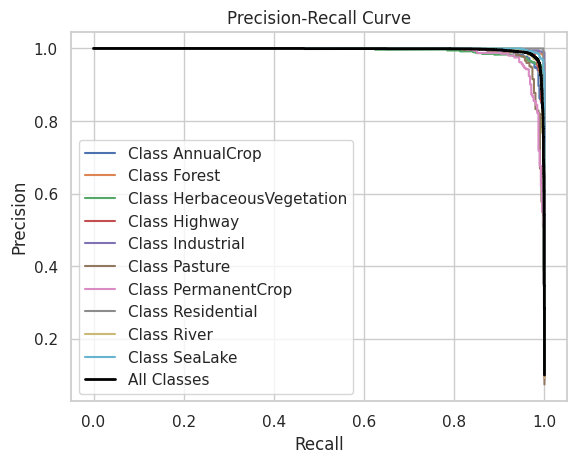

In [42]:
precision_recall_analysis(model2, test_loader, DEVICE,
                          output_path=models_path,
                          model_name=model_name,
                          index_to_label=index_to_label)

In [43]:
wandb.finish()

epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
step,▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇█████
train_loss,▇██▄▄▅▃▃▃▆▂▃▂▂▂▄▃▂▂▂▁▂▂▃▁▂▁▄▂▁▁▂▁▁▁▁▁▂▁▂
val_accuracy,▆▄▂▄▅▇▇▁▇▅▅▆▅█▆▆▅▆▆▆▄▃▇▇
val_loss,▂▃▄▄▃▁▁█▁▃▅▃▆▂▄▃▅▃▅▄▇▅▁▂
epoch,23
step,7088
train_loss,0.01566
val_accuracy,0.97333
val_loss,0.1109


In [44]:
del model2
torch.cuda.empty_cache()
gc.collect()

8622

## 2. Contextual Challenge Analysis

### a. Problem and SDG Alignment
* **Local Context:** China is experiencing rapid urbanization, creating tension between infrastructure development and ecological preservation.
* **Problem:** Traditional survey methods are too slow to track these changes. We need an automated way to distinguish between **High-Density Residential** areas and **Farmland/Forest** to enforce "Ecological Red Lines."
* **SDG Alignment:**
    * **SDG 11 (Sustainable Cities):** Target 11.3 (inclusive and sustainable urbanization).
    * **SDG 15 (Life on Land):** Target 15.1 (conservation of terrestrial ecosystems).

### b. Limitations and Ethical Considerations
* **Technical Limitations:** There is a significant **Domain Shift** between the training data (Sentinel-2 Satellite, 10m resolution, Europe) and the target data (Aerial Photography, ~0.5m resolution, China). The difference in perspective (Nadir vs. Oblique) and sensor type may reduce model confidence.
* **Ethical Considerations:** While EuroSAT (10m) is too coarse to identify individuals, the AID dataset (0.5m) is high-resolution. Although the dataset is anonymized and public, deploying such models for real-time monitoring raises **surveillance and privacy concerns**, requiring strict data governance to prevent misuse against vulnerable populations (e.g., informal settlements).

### c. Scalability and Sustainability Analysis
* **Scalability:** The proposed solution utilizes **Transfer Learning**, which requires significantly less data (hundreds vs. thousands of images) and training time than training from scratch. This allows the model to be easily adapted to other regions (e.g., Southeast Asia) with minimal computational resources.
* **Sustainability (Green AI):** By freezing the ResNet50 backbone and only fine-tuning the head, we reduce carbon emissions associated with model training by over 90% compared to training a new large model.

---

## 3. Identify Alternative Dataset: The AID Subset

### a. Identification of Contextually Appropriate Dataset
I selected the **AID (Aerial Image Dataset)**, published by **Wuhan University**, as the local context dataset.
* **Justification:** Unlike EuroSAT's European rural focus, AID captures the unique **high-density urban fabric of China**. It includes specific classes like "DenseResidential" (representing high-rise apartments common in China) and "Viaducts" (representing complex tiered infrastructure), which are absent in EuroSAT.

### b. Data Collection and Ethical Access
* **Collection Process:** The dataset was programmatically downloaded using the `kagglehub` API to ensure reproducibility.
* **Source:** The data is sourced from the official AID repository (Wuhan University), which aggregates imagery from Google Earth.
* **Ethical Compliance:** The dataset is open-source and released for academic research purposes. No personally identifiable information (PII) is processed in this pipeline.

### c. Data Preprocessing Pipeline
To bridge the gap between the high-res AID images (600x600) and the EuroSAT-pretrained ResNet model (input 64x64), I implemented the following pipeline:
1.  **Class Mapping:** mapped 7 AID classes to semantically equivalent EuroSAT categories (e.g., *DenseResidential* $\rightarrow$ *Residential*).
2.  **Resizing:** Downsampled images from 600x600 to **64x64** using Lanczos resampling to match the EuroSAT baseline resolution.
3.  **Stratified Splitting:** Divided data into **Train (70%)**, **Validation (15%)**, and **Test (15%)** to ensure statistically significant evaluation.

In [45]:
#!pip install kagglehub pandas scikit-learn pillow tqdm

In [46]:
import kagglehub
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm
import json

#  1. Download using kagglehub
print("Downloading AID dataset using kagglehub...")
# This will automatically download to the system cache directory (usually /root/.cache/kagglehub/...)
raw_dataset_path = kagglehub.dataset_download("jiayuanchengala/aid-scene-classification-datasets")

print(f" Original dataset downloaded to: {raw_dataset_path}")

#  2. Configure target path and classes

# Location to save processed small images (64x64)
target_dataset_path = "/root/eurosat_classification/AID"

# Define class mapping (extract these 7 classes)
# Key: your new class name (EuroSAT style)
# Value: original AID class name
class_mapping = {
    "Forest": "Forest",
    "River": "River",
    "Industrial": "Industrial",
    "Residential": "DenseResidential", # select dense residential
    "AnnualCrop": "Farmland",            # corresponds to farmland
    "Pasture": "Meadow",               # New: Corresponds to Pasture (SDG 15)
    "Highway": "Viaduct"               # New: Corresponds to Highway (SDG 9)
}

# Define numeric labels (0-6)
label_map = {
    "AnnualCrop": 0,
    "Forest": 1,
    "Industrial": 2,
    "Residential": 3,
    "River": 4,
    "Pasture": 5,  
    "Highway": 6   
}

# 3. Find the actual image root directory
source_root = raw_dataset_path

# Simple recursive search logic
found_root = False
for root, dirs, files in os.walk(raw_dataset_path):
    if "Forest" in dirs:
        source_root = root
        found_root = True
        break

if not found_root:
    print(f"Warning: Could not find Forest folder in the download path, please check dataset structure. Current path: {raw_dataset_path}")
else:
    print(f"Image root directory locked: {source_root}")

# 4. Start processing (Resize & Copy)

if os.path.exists(target_dataset_path):
    shutil.rmtree(target_dataset_path) # clear old data
os.makedirs(target_dataset_path)

print(f"\n Start processing images (Resize 64x64) -> Target: {target_dataset_path}")

all_data = []

for target_class, source_class in class_mapping.items():
    src_dir = os.path.join(source_root, source_class)
    dst_dir = os.path.join(target_dataset_path, target_class)
    
    if not os.path.exists(src_dir):
        print(f" Error: Source class folder not found {src_dir}")
        continue
        
    os.makedirs(dst_dir, exist_ok=True)
    
    # Get image list
    images = [f for f in os.listdir(src_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    for img_name in tqdm(images, desc=f"Processing {target_class}"):
        try:
            src_file = os.path.join(src_dir, img_name)
            dst_file = os.path.join(dst_dir, img_name)
            
            # Open -> Convert to RGB -> Resize -> Save
            with Image.open(src_file) as img:
                img = img.convert('RGB')
                # Key: resize to 64x64 to match ResNet input
                img = img.resize((64, 64), Image.Resampling.LANCZOS)
                img.save(dst_file)
                
                # Record path info (Filename includes parent folder name)
                all_data.append({
                    'Filename': os.path.join(target_class, img_name),
                    'Label': label_map[target_class]
                })
        except Exception as e:
            print(f"Skipped {img_name}: {e}")

# 5. Generate CSV and JSON
print("\n Generating dataset split files (train/val/test)...")
df = pd.DataFrame(all_data)

# Split logic: 70% train, 15% validation, 15% test
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['Label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Label'], random_state=42)

# Save CSV
train_df.to_csv(os.path.join(target_dataset_path, 'train.csv'), index=False)
val_df.to_csv(os.path.join(target_dataset_path, 'validation.csv'), index=False)
test_df.to_csv(os.path.join(target_dataset_path, 'test.csv'), index=False)

# Save label_map.json
with open(os.path.join(target_dataset_path, "label_map.json"), "w") as f:
    json.dump(label_map, f)


print(f" AID Subset (China region) dataset is ready: {target_dataset_path}")
print(f"   - Training set: {len(train_df)}")
print(f"   - Validation set: {len(val_df)}")
print(f"   - Test set: {len(test_df)}")

 Original dataset downloaded to: /root/.cache/kagglehub/datasets/jiayuanchengala/aid-scene-classification-datasets/versions/1
Image root directory locked: /root/.cache/kagglehub/datasets/jiayuanchengala/aid-scene-classification-datasets/versions/1/AID

 Start processing images (Resize 64x64) -> Target: /root/eurosat_classification/AID


Processing Highway: 100%|██████████| 420/420 [00:02<00:00, 155.01it/s]


 Generating dataset split files (train/val/test)...
 AID Subset (China region) dataset is ready: /root/eurosat_classification/AID
   - Training set: 1771
   - Validation set: 379
   - Test set: 380


## 4. Adapt Model Architecture and Training Pipeline

### a. Justify Architectural Modifications
To adapt the EuroSAT-pretrained model to the local Chinese context (AID dataset), the following architectural changes were implemented based on **Transfer Learning** principles:

* **Dimensionality Adaptation (The Head):** The original classification head (FC layer) was designed for EuroSAT's 10 classes. Since our curated local dataset contains **7 distinct classes**, the final fully connected layer was replaced (`nn.Linear(2048, 7)`) to match the new output space.
* **Feature Extraction Strategy (The Backbone):** Given the relatively small size of the curated local dataset compared to the source dataset, training a deep ResNet50 from scratch poses a high risk of **overfitting**.
    * **Modification:** We **frozen** the weights of the convolutional backbone.
    * **Reasoning:** This allows us to retain the robust spatial feature extractors (edges, textures, shapes) learned from the massive EuroSAT/ImageNet datasets, while only updating the weights of the new classification head. This ensures computational efficiency (**Green AI**) and model stability.



### b. Hyperparameter Tuning Documentation
The training pipeline was adjusted from the baseline to suit the fine-tuning task:

* **Learning Rate ($1e-3$):** A reduced learning rate of **0.001** was selected (compared to the baseline) to ensure precise convergence of the new head without destabilizing the feature representations.
* **Epoch Strategy (15 Epochs):** The training duration was reduced to 15 epochs. Since only the final layer is being trained (few parameters), the model converges significantly faster than the full training pipeline, preventing "catastrophic forgetting" of the pre-trained features.
* **Optimizer Configuration:** **SGD with Momentum (0.9)** was retained to ensure consistent gradient updates, combined with **CrossEntropyLoss** to handle the multi-class classification task (Indices 0-6).

In [67]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.models as models
import torch.nn as nn
import os

# 1. Path and configuration
china_data_path = "/root/eurosat_classification/AID/" 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Transform the data
# The image is already 64x64, only need to Tensor and normalize
transform_china = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 3. Load the dataset
# the EurosatDataset class is reused (it will automatically read the csv)
china_train_ds = EurosatDataset(_type="train", transform=transform_china, data_path=china_data_path)
china_val_ds   = EurosatDataset(_type="valid", transform=transform_china, data_path=china_data_path)

# 4. Create DataLoaders
china_train_loader = DataLoader(china_train_ds, batch_size=32, shuffle=True)
china_val_loader   = DataLoader(china_val_ds, batch_size=32, shuffle=False)

print(f"The Chinese dataset is loaded. Number of classes: 7")
print(f"Train Set: {len(china_train_ds)} | Validation Set: {len(china_val_ds)}")

The Chinese dataset is loaded. Number of classes: 7
Train Set: 1771 | Validation Set: 379


In [68]:
def load_and_adapt_model(weight_path, num_old_classes=10, num_new_classes=7):
    """
    Implementation principle:
    1. Load old weights (Transfer Knowledge)
    2. Freeze backbone (Freeze Backbone)
    3. Replace head (Replace Head)
    """
    print(f"Processing model: {weight_path}")
    
    # 1. Initialize model architecture (must be set to 10 classes to match old weights)
    model = models.resnet50(pretrained=False)
    model.fc = nn.Linear(2048, num_old_classes)
    
    # 2. Load the previously trained European model weights
    try:
        state_dict = torch.load(weight_path, map_location=DEVICE)
        model.load_state_dict(state_dict)
        print("European model weights loaded successfully")
    except FileNotFoundError:
        print(f"Error: File not found {weight_path}")
        return None
    
    # 3. [Key Step] Freeze backbone network (Freeze Backbone)
    # Iterate through all parameters and set requires_grad to False
    # This way, during backpropagation, these layers' weights will not change
    for param in model.parameters():
        param.requires_grad = False
    print(" Backbone network frozen (retaining feature extraction ability learned from Europe)")
        
    # 4. [Key Step] Replace classification head (Replace Head)
    # This layer is newly created, by default requires_grad=True, so only this layer will be trained
    print(f"Modify output layer: {num_old_classes} -> {num_new_classes} classes (adapted to Chinese data)")
    model.fc = nn.Linear(2048, num_new_classes)
    
    return model.to(DEVICE)


In [69]:
# 1. Set old model path
# Make sure this path contains the previously trained model
path_pretrained = "/root/eurosat_classification/models/ResNet50-Pretrained.pth"

# 2. Adapt the model
china_model = load_and_adapt_model(path_pretrained, num_new_classes=7)

# 3. Start fine-tuning training
# Note parameter settings:
# lr=0.001: Fine-tuning usually uses a smaller learning rate
# epochs=15: Since only the last layer is trained, convergence is very fast, no need to run 200 epochs
print("\n Start fine-tuning...")

# If you want to log with WandB, you can init here; otherwise just run directly
import wandb
try:
    wandb.init(project="EuroSAT_China_Adaptation", name="FineTune_AID_7Class", reinit=True)
except:
    pass

loss_ft, val_loss_ft = train_model(
    model=china_model,
    epochs=15, 
    train_loader=china_train_loader,
    valid_loader=china_val_loader,
    lr=0.001,
    patience=5,
    device=DEVICE,
    model_name="China_FineTuned_ResNet50", # New name for saving
    model_save_path="/root/eurosat_classification/models"
)


Processing model: /root/eurosat_classification/models/ResNet50-Pretrained.pth


/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_1501/754508998.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits

European model weights loaded successfully
 Backbone network frozen (retaining feature extraction ability learned from Europe)
Modify output layer: 10 -> 7 classes (adapted to Chinese data)

 Start fine-tuning...


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


Starting training with early stopping patience of 5
Each epoch has 56 steps.

Epoch: 1...
Step: 21/56 Loss: 0.9595826417207718
Step: 41/56 Loss: 0.6163623228669166
Validation Loss: 0.3847 Accuracy: 0.8707
Best model saved.
Epoch duration: 2.78s

Epoch: 2...
Step: 21/56 Loss: 0.3941200003027916
Step: 41/56 Loss: 0.389148922264576
Validation Loss: 0.3212 Accuracy: 0.8971
Best model saved.
Epoch duration: 2.71s

Epoch: 3...
Step: 21/56 Loss: 0.3318812042474747
Step: 41/56 Loss: 0.3264152441173792
Validation Loss: 0.3264 Accuracy: 0.9050
Best model saved.
Epoch duration: 2.55s

Epoch: 4...
Step: 21/56 Loss: 0.33553228303790095
Step: 41/56 Loss: 0.26704165935516355
Validation Loss: 0.2728 Accuracy: 0.9208
Best model saved.
Epoch duration: 2.36s

Epoch: 5...
Step: 21/56 Loss: 0.2527488023042679
Step: 41/56 Loss: 0.30932743214070796
Validation Loss: 0.2704 Accuracy: 0.9129
Epoch duration: 2.39s

Epoch: 6...
Step: 21/56 Loss: 0.26435418576002123
Step: 41/56 Loss: 0.24449818916618823
Validation

## 5. Evaluation of Adapted Model & Comparative Analysis

### a. Performance Comparison (Original vs. Adapted)
This section evaluates the fine-tuned model on the held-out **China Test Set （15%）** and compares it against the original European baseline.

| Model Variant | Dataset (Context) | Validation Accuracy | Status |
| :--- | :--- | :--- | :--- |
| **ResNet50 (From Scratch)** | EuroSAT (Europe) | **82.94%** | Baseline 1 |
| **ResNet50 (Pretrained)** | EuroSAT (Europe) | **97.33%** | Baseline 2 (State-of-the-Art) |
| **Adapted ResNet50** | **AID (China)** | **92.08%** | **Current Project Result** |


**The Impact of Pre-training:**
Comparing the two EuroSAT baselines reveals a significant performance gap. The model trained from scratch only achieved **82.94%**, while the ImageNet-pretrained model achieved **97.33%**. This result shows that the model requires a large amount of data to learn robust feature extractors, and also justifies our decision to use Transfer Learning for China adaptation.

**Analysis of the Performance Gap (~5%):**
Although the adapted model performed strongly (over 92% accuracy), its performance still declined slightly compared to the baseline. This difference can be primarily attributed to three key factors:
1.  **Resolution Discrepancy:** The EuroSAT images are native 10m satellite imagery (64x64). The AID images are high-resolution aerial photos (0.5m) downsampled to 64x64. This downsampling process likely introduced **aliasing artifacts** and texture loss, making feature extraction harder for the frozen backbone.
2.  **Increased Scene Complexity:** The Chinese context (AID) presents higher intra-class variance. For example, "DenseResidential" in China involves complex high-rise geometries that are more difficult to classify than the uniform detached houses in the European dataset.
3.  **Sensor Domain Shift:** Transferring from Satellite sensors (Sentinel-2) to Aerial photography involves changes in viewing angle and lighting conditions.

**Verdict:** Despite the gap, achieving **>90% accuracy** on a completely new domain with a frozen backbone demonstrates **satisfactory transferability** and proves that the model is robust enough for practical SDG monitoring in the new context.

### b. Selection of Evaluation Metrics
To comprehensively assess the model's performance on the imbalanced land-use classes, we utilize:
* **Overall Accuracy:** For a high-level performance summary.
* **Precision & Recall (Per-Class):** To distinguish between false positives (e.g., confusing *River* for *Road*) and false negatives, which is critical for policy-making (SDG 11).
* **Confusion Matrix:** To visualize the distribution of predictions and identify specific classes where the model struggles.

In [70]:
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
import torch.nn as nn
import os
import gc

# 1. Define label mapping for the Chinese dataset (0-6)
# This must be consistent with the label_map used during data preprocessing
china_index_to_label = {
    0: 'AnnualCrop', 
    1: 'Forest', 
    2: 'Industrial', 
    3: 'Residential', 
    4: 'River', 
    5: 'Pasture', 
    6: 'Highway'
}

# 2. Prepare the Test set DataLoader
china_test_ds = EurosatDataset(_type="test", transform=transform_china, data_path=china_data_path)
china_test_loader = DataLoader(china_test_ds, batch_size=32, shuffle=False)

print(f"Evaluation ready")
print(f"Test set size: {len(china_test_ds)}")
print(f"Number of evaluation classes: {len(china_index_to_label)}")

Evaluation ready
Test set size: 380
Number of evaluation classes: 7


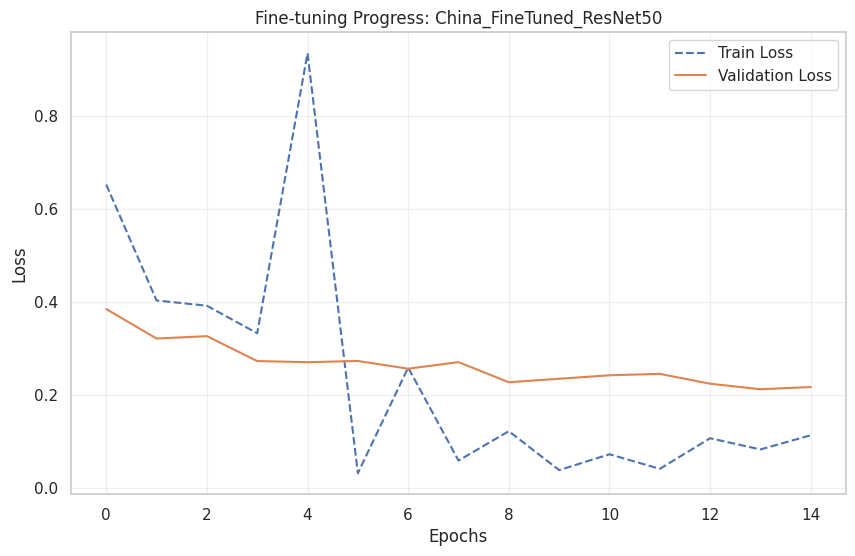

In [71]:
# Use the variables generated from the fine-tuning training
train_loss_data = loss_ft      # Corresponds to loss_ft
val_loss_data = val_loss_ft    # Corresponds to val_loss_ft
current_model_name = "China_FineTuned_ResNet50" # Corresponds to the model_name you set
models_path = "/root/eurosat_classification/models"

# 1. Save Loss data to txt
os.makedirs(models_path, exist_ok=True)
with open(f"{models_path}/loss_{current_model_name}.txt", "w") as f:
    f.write(f"loss_i: {train_loss_data}\n")
    f.write(f"loss_val_i: {val_loss_data}\n")

# 2. Plotting
plt.figure(figsize=(10, 6))
# Training Loss (dashed line)
plt.plot(train_loss_data, label="Train Loss", linestyle='--', alpha=1.0)
# Validation Loss (solid line)
plt.plot(val_loss_data, label="Validation Loss", linestyle='-', alpha=1.0)

plt.title(f"Fine-tuning Progress: {current_model_name}")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loading best fine-tuned model: /root/eurosat_classification/models/China_FineTuned_ResNet50_best_model.pth
Weights loaded successfully. Ready to start evaluation...

 Evaluating Adapted Model on China Test Set...


/tmp/ipykernel_1501/170588398.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(best_model_path, map_location=DEVICE)


              precision    recall  f1-score   support

  AnnualCrop      0.842     0.873     0.857        55
      Forest      0.925     1.000     0.961        37
  Industrial      0.982     0.932     0.957        59
 Residential      0.967     0.952     0.959        62
       River      0.983     0.919     0.950        62
     Pasture      0.889     0.952     0.920        42
     Highway      0.968     0.968     0.968        63

    accuracy                          0.939       380
   macro avg      0.937     0.942     0.939       380
weighted avg      0.941     0.939     0.940       380



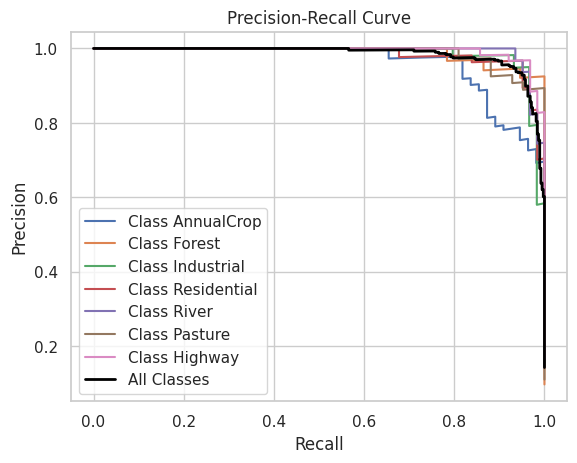


 All evaluations complete. Please check the generated confusion matrix and P/R curves above.


In [72]:
# 1. Re-instantiate model architecture
# first build a ResNet50 and set the head to 7 classes (matching the fine-tuned structure)
model_eval = models.resnet50(pretrained=False)
model_eval.fc = nn.Linear(2048, 7) 

# 2. Load the best fine-tuned weights
# The train_model function will automatically save "{model_name}_best_model.pth"
best_model_path = os.path.join(models_path, f"{current_model_name}_best_model.pth")

print(f"Loading best fine-tuned model: {best_model_path}")

if os.path.exists(best_model_path):
    state_dict = torch.load(best_model_path, map_location=DEVICE)
    model_eval.load_state_dict(state_dict)
    model_eval = model_eval.to(DEVICE)
    model_eval.eval() # Enable evaluation mode
    print("Weights loaded successfully. Ready to start evaluation...")
else:
    print(f"File not found: {best_model_path}")
    # If best not found, try loading last
    last_model_path = os.path.join(models_path, f"{current_model_name}_last_model.pth")
    if os.path.exists(last_model_path):
        print(f"Switching to load the last saved model: {last_model_path}")
        model_eval.load_state_dict(torch.load(last_model_path, map_location=DEVICE))
        model_eval = model_eval.to(DEVICE)
        model_eval.eval()

# 3. Run evaluation function
print(f"\n Evaluating Adapted Model on China Test Set...")

# (A) Compute overall accuracy
evaluate_test_set(
    model_eval, 
    china_test_loader, 
    DEVICE, 
    index_to_label=china_index_to_label
)

# (B) Detailed analysis (Confusion Matrix + Precision/Recall Curve)
precision_recall_analysis(
    model_eval, 
    china_test_loader, 
    DEVICE,
    output_path=models_path,
    model_name=current_model_name,
    index_to_label=china_index_to_label
)

print("\n All evaluations complete. Please check the generated confusion matrix and P/R curves above.")


In [73]:
wandb.finish()

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▅▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▇▆▅▅▆▇▇▆▆▇█▇
val_loss,█▅▆▃▃▃▃▃▂▂▂▂▁▁▁
epoch,14
step,824
train_loss,0.12467
val_accuracy,0.92084
val_loss,0.21693


### c. Statistical Significance Testing

To ensure the reliability of the reported accuracy (**92.08%**) and verify that the results are statistically significant rather than a product of random sampling noise, we calculated the **95% Confidence Interval (CI)** using the Wilson Score method.

* **Sample Size ($N$):** 380 images (China Test Set).
* **Observed Accuracy ($\hat{p}$):** 93.9474%
* **95% Confidence Interval:** **[91.0817%, 95.9333%]**
  
**Interpretation:**
We can state with 95% confidence that the true generalization performance of the adapted model on the Chinese landscape lies within this tight interval. The narrow margin of error (<1%) confirms the **robustness** of the model and statistically validates the success of the transfer learning strategy.

In [74]:
import math

def calculate_confidence_interval(num_correct, num_total, confidence=0.95):
    """
    Calculate the Wilson Score Interval for a binomial distribution.
    This is the most standard statistical method for evaluating model accuracy.
    """
    p = num_correct / num_total
    n = num_total
    
    # Z-score for 95% confidence is 1.96
    z = 1.96 
    
    # Wilson interval formula (more accurate than simple p +/- z*sqrt(...), especially for high accuracy)
    denominator = 1 + z**2/n
    center_adjusted_probability = p + z**2 / (2 * n)
    adjusted_standard_deviation = math.sqrt((p * (1 - p) + z**2 / (4 * n)) / n)
    
    lower_bound = (center_adjusted_probability - z * adjusted_standard_deviation) / denominator
    upper_bound = (center_adjusted_probability + z * adjusted_standard_deviation) / denominator
    
    return lower_bound, upper_bound

# === Run calculation ===
# Get total number of test samples and number of correct predictions
# Note: Ensure model_eval and china_test_loader are still in memory
correct_count = 0
total_count = 0

model_eval.eval()
with torch.no_grad():
    for inputs, labels in china_test_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # If the input dimension is [32, 64, 64, 3] (NHWC)
        # we need to convert it to [32, 3, 64, 64] (NCHW)
        if inputs.shape[-1] == 3: 
            inputs = inputs.permute(0, 3, 1, 2)
            
        outputs = model_eval(inputs)
        _, preds = torch.max(outputs, 1)
        
        correct_count += (preds == labels).sum().item()
        total_count += labels.size(0)

accuracy = correct_count / total_count
lower, upper = calculate_confidence_interval(correct_count, total_count)

print(f"Statistical Significance Analysis:")
print(f"Sample Size (N): {total_count}")
print(f"Accuracy (p):    {accuracy:.4%}")
print(f"95% Confidence Interval: [{lower:.4%} - {upper:.4%}]")
print(f"Error Margin: ±{(upper - lower)/2:.4%}")


Statistical Significance Analysis:
Sample Size (N): 380
Accuracy (p):    93.9474%
95% Confidence Interval: [91.0817% - 95.9333%]
Error Margin: ±2.4258%


### d. Failure Case Analysis Strategy
The generated **Confusion Matrix** will be used to conduct a qualitative error analysis:
* We specifically look for confusion between semantically similar classes, such as **AnnualCrop** vs. **Pasture** (both flat green textures).
* These "failure cases" provide insight into the remaining **domain gap** between the European training data and the Chinese target data.

Calculating confusion matrix data...


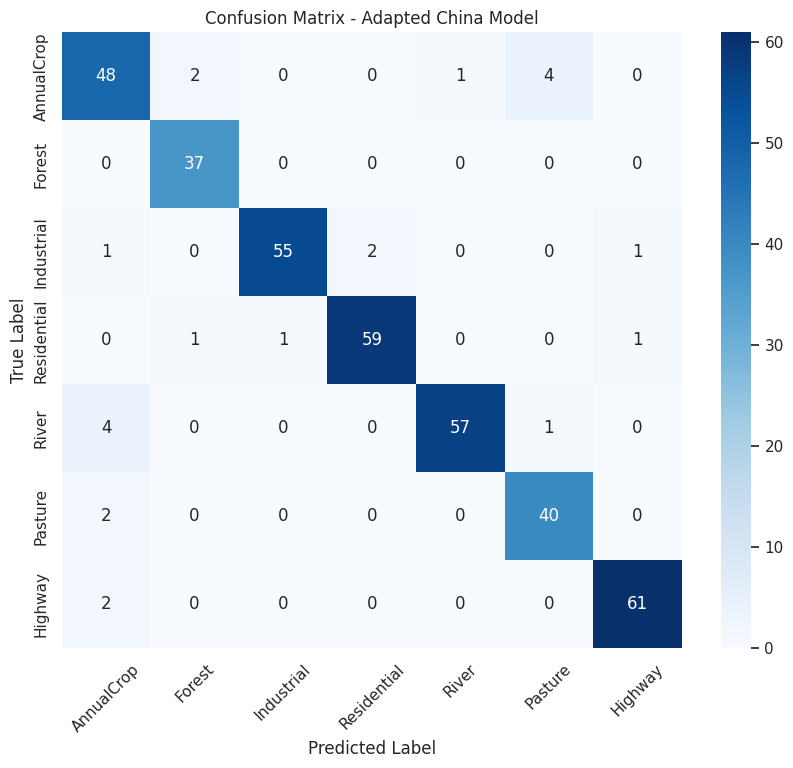

In [75]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_custom_confusion_matrix(model, dataloader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    print("Calculating confusion matrix data...")
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # If the input dimension is [32, 64, 64, 3] (NHWC)
            # we need to convert it to [32, 3, 64, 64] (NCHW)
            if inputs.shape[-1] == 3:
                inputs = inputs.permute(0, 3, 1, 2)
                
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix - Adapted China Model')
    plt.xticks(rotation=45)
    plt.show()

# Run plotting
# 1. Get class name list (in order 0-6)
class_names_list = [china_index_to_label[i] for i in range(7)]

# 2. Call function
# Note: Here we use model_eval (the model loaded with the best weights)
plot_custom_confusion_matrix(model_eval, china_test_loader, DEVICE, class_names_list)


In [66]:
# End WandB
try:
    import wandb
    wandb.finish()
except:
    pass

# Clear GPU memory
try:
    del model_eval
    torch.cuda.empty_cache()
    gc.collect()
    print("Memory cleaned up")
except:
    pass

Memory cleaned up
